# MScBMI 33200 – Machine Learning for Biomedical Informatics
# Assignment IV
Name: Troy Zhongyi Zhang
Netid: zhongyiz@uchicago.edu

### Directions:
1.	Fill out below information (tables and methods)
2.	Submit this document along with your code in an HTML/PDF format

### Section 1: EMR Bots 30-day Readmission study
Using the training datasets, create the following models:
1.	Naïve model: This model utilizes only patient characteristics (age, gender and race) to predict 30-day readmission in a logistic regression framework

2.	GLM model : This model utilizes patient characteristics and most-recent lab recordings to predict 30-day admissions in a logistic regression framework.

3.	ANN model: This model utilizes patient characteristics and most-recent lab recordings to predict 30-day admissions using an artificial neural network. Feature engineering steps include balancing classes using SMOTE as well as data normalization/standardization of continuous variables.

4.	RF Model : This model utilizes patient characteristics and most-recent lab recordings to predict 30-day admissions using a random forest.

5.	GBM Model: This model utilizes patient characteristics and most-recent lab recordings to predict 30-day admissions using a gradient boosted machine.
Utilize a five-fold cross-validation technique to build your model. 
Calculate AUC on the test dataset. Fill out the following Table.
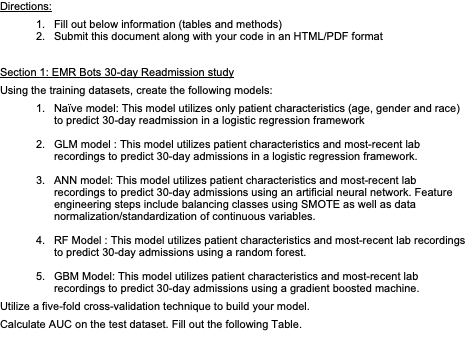

In [1]:
import pandas as pd
import numpy as np
from random import seed
seed(1)

In [2]:
r_outcome = pd.read_csv("readmission_outcome.csv")
info = pd.read_csv("encounter_info.csv")
#df1 = pd.merge(info, r_outcome, on = "Encounter_ID")
labs = pd.read_csv("encounter_labs.csv")

In [3]:
labs = labs.groupby(['Encounter_ID']).tail(1)
labs = labs.reset_index(drop=True)
wrong_ids = labs.iloc[:7]
wrong_ids['Encounter_ID'] = pd.DataFrame(wrong_ids['Encounter_ID'
                                                  ]).applymap(lambda x: x.replace('1e+05', '100000'))
labs.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Encounter_ID,Lab_DTTM,CBC..ABSOLUTE.LYMPHOCYTES,CBC..ABSOLUTE.NEUTROPHILS,CBC..BASOPHILS,CBC..EOSINOPHILS,CBC..HEMATOCRIT,CBC..HEMOGLOBIN,CBC..PLATELET.COUNT,CBC..RED.BLOOD.CELL.COUNT,CBC..WHITE.BLOOD.CELL.COUNT,METABOLIC..ALBUMIN,METABOLIC..BILI.TOTAL,METABOLIC..BUN,METABOLIC..CALCIUM,METABOLIC..CREATININE,METABOLIC..POTASSIUM,METABOLIC..SODIUM
0,100000_1,1981-01-08 23:28:24,32.8,76.4,0.0,0.1,35.9,14.8,386.0,4.8,10.7,5.8,0.8,12.6,11.1,0.9,4.1,135.5
1,100000_2,1996-02-06 17:07:30,16.1,77.9,0.2,0.4,49.6,16.2,339.2,5.8,6.4,2.7,0.9,15.6,8.1,1.2,4.7,140.9
2,100000_3,2002-04-11 00:36:27,23.4,66.2,0.1,0.4,40.4,18.7,408.7,3.2,8.5,3.7,0.3,15.1,7.9,0.7,5.3,150.0
3,100000_4,2006-11-29 12:01:11,15.7,78.3,0.0,0.2,54.4,18.9,128.6,5.9,7.0,4.0,0.9,24.4,7.0,1.1,4.4,155.0
4,100000_5,2007-04-27 16:49:40,27.4,62.2,0.1,0.4,45.2,16.8,315.4,4.9,11.8,5.9,0.1,21.4,7.5,0.8,5.6,137.1


In [4]:
read1 = pd.merge(info, labs, on = "Encounter_ID")
read = pd.merge(read1,r_outcome, on = "Encounter_ID")
read['PatientGender'] = read['PatientGender'].replace('Female',1)
read['PatientGender'] = read['PatientGender'].replace('Male',0)
read['PatientGender'] = read['PatientGender'].astype('category').cat.codes

read['PatientRace'] = read['PatientRace'].replace('African American',0)
read['PatientRace'] = read['PatientRace'].replace('White',1)
read['PatientRace'] = read['PatientRace'].replace('Asian',2)
read['PatientRace'] = read['PatientRace'].replace('Unknown',3)
read['PatientRace'] = read['PatientRace'].astype('category').cat.codes

read_train = read[read["AdmissionEndDate"].str[:4].astype(int)<=2004]
read_test = read[read["AdmissionEndDate"].str[:4].astype(int)>2004]
# read_train = read_train.reset_index(drop=True)
# read_test = read_test.reset_index(drop=True)

read_Xtrain1 = read_train[['PatientEncounterAge','PatientGender','PatientRace']]
read_ytrain1 = read_train[['outcome']]
read_Xtest1 = read_test[['PatientEncounterAge','PatientGender','PatientRace']]
read_ytest1 = read_test[['outcome']]

# Naïve model: 

### readmission - read

In [5]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from random import seed
seed(0)
# skf = StratifiedKFold(n_splits=5)
params1 = {'var_smoothing' : [1e-10,1e-9,1e-7,1e-5,1e-3]}
nb = GaussianNB()
gs1 = GridSearchCV(nb, cv=5, param_grid=params1, scoring = 'roc_auc',refit = True, n_jobs=-1, verbose = 5, return_train_score=True)

gs1.fit(read_Xtrain1, read_ytrain1)
gs1.cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:    2.1s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:    2.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mean_fit_time': array([0.01098027, 0.01187506, 0.01067371, 0.01098475, 0.00743365]),
 'std_fit_time': array([0.00046294, 0.00205628, 0.00064158, 0.00066528, 0.00163095]),
 'mean_score_time': array([0.00680275, 0.00860696, 0.00756755, 0.00757775, 0.00481987]),
 'std_score_time': array([0.00033094, 0.00157957, 0.00108967, 0.00098609, 0.00071321]),
 'param_var_smoothing': masked_array(data=[1e-10, 1e-09, 1e-07, 1e-05, 0.001],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'var_smoothing': 1e-10},
  {'var_smoothing': 1e-09},
  {'var_smoothing': 1e-07},
  {'var_smoothing': 1e-05},
  {'var_smoothing': 0.001}],
 'split0_test_score': array([0.4152807 , 0.4152807 , 0.41529528, 0.4155433 , 0.42218137]),
 'split1_test_score': array([0.53448226, 0.53448226, 0.53448226, 0.53470114, 0.55580201]),
 'split2_test_score': array([0.5161248 , 0.5161248 , 0.5161248 , 0.51625613, 0.51646042]),
 'split3_test_score': array([0.72176823

In [6]:
gs1.best_params_

{'var_smoothing': 0.001}

In [7]:
gs1.best_estimator_

GaussianNB(priors=None, var_smoothing=0.001)

In [8]:
y_pred1 = gs1.best_estimator_.predict(read_Xtest1)
y_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
prob1 = gs1.best_estimator_.predict_proba(read_Xtest1) 
prob1

array([[0.99597631, 0.00402369],
       [0.99524932, 0.00475068],
       [0.99602356, 0.00397644],
       ...,
       [0.98229542, 0.01770458],
       [0.99532479, 0.00467521],
       [0.99431079, 0.00568921]])

In [10]:
from sklearn import metrics
nb_matrix1 = metrics.confusion_matrix(read_ytest1, y_pred1)
nb_matrix1

array([[14599,     0],
       [   50,     0]])

In [11]:
target_names1 = ['Not in 30 days', 'Readmitted within 30 days']
from sklearn.metrics import classification_report
print("", classification_report(read_ytest1, y_pred1, target_names=target_names1))

                            precision    recall  f1-score   support

           Not in 30 days       1.00      1.00      1.00     14599
Readmitted within 30 days       0.00      0.00      0.00        50

                 accuracy                           1.00     14649
                macro avg       0.50      0.50      0.50     14649
             weighted avg       0.99      1.00      0.99     14649



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
from sklearn.metrics import roc_auc_score
nb_probs = gs1.best_estimator_.predict_proba(read_Xtest1)[:,1]
print(roc_auc_score(read_ytest1, nb_probs))

0.4905582574148914


In [13]:
from sklearn.metrics import accuracy_score
as1 = accuracy_score(read_ytest1, y_pred1)

In [14]:
as1

0.9965867977336337

In [15]:
error1 = 1-as1
error1

0.003413202266366322

In [16]:
n1 = len(y_pred1)

In [17]:
import math
error1 + 1.96 * math.sqrt((error1 * (1 - error1)) / n1)

0.004357677685114603

In [18]:
error1 - 1.96 * math.sqrt((error1 * (1 - error1)) / n1)

0.0024687268476180405

In [19]:
import numpy as np, scipy.stats as st
st.t.interval(0.95, len(read_ytest1)-1, loc=np.mean(read_ytest1), scale=st.sem(read_ytest1))

(array([0.00246863]), array([0.00435777]))

In [20]:
read_ytest1 = read_ytest1.values

Original ROC area: 0.4906


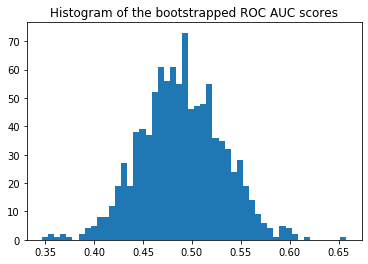

Confidence interval for the score: [0.4232 - 0.5571]


In [22]:
#Calculated the Confidence Interval by bootstrapping
import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_pred = nb_probs
y_true = read_ytest1

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [23]:
#Transplanted the pROC package from R into Python for CI computation
import numpy as np
import scipy.stats
from scipy import stats

read_ytest1=read_ytest1.reshape((14649,))
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
y_pred = nb_probs
y_true = read_ytest1

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.4905582574148914
AUC COV: 0.0016752140380696195
95% AUC CI: [0.41033815 0.57077837]


# Logistic Regression model

In [24]:
read_Xtrain2 = read_train.drop(["Patient_ID","Encounter_ID","AdmissionStartDate",
                                "AdmissionEndDate","Lab_DTTM", "outcome"],axis=1)
read_ytrain2 = read_train[['outcome']]
read_Xtest2 = read_test.drop(["Patient_ID","Encounter_ID","AdmissionStartDate",
                              "AdmissionEndDate","Lab_DTTM", "outcome"],axis=1)
read_ytest2 = read_test[['outcome']]

In [25]:
from sklearn.linear_model import LogisticRegression
seed(0)
# skf = StratifiedKFold(n_splits=5)
params2 = {'tol' : [1e-6,1e-5,1e-4,1e-3,1e-2],
           'C': [0.5,1.0,1.5,2.0,2.5]}
lg1 = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
lg1 = GridSearchCV(lg1, cv=5, param_grid=params2, scoring = 'roc_auc',refit = True, 
                   n_jobs=-1, verbose = 5, return_train_score=True)

lg1.fit(read_Xtrain2, read_ytrain2)
lg1.cv_results_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   13.5s finished
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'mean_fit_time': array([0.99134631, 1.05234489, 1.1355967 , 1.14954338, 1.11083565,
        1.13382444, 1.11382279, 1.10081606, 1.08704262, 1.05061502,
        1.05289245, 1.03408618, 1.0322576 , 1.02176347, 1.01946154,
        1.01821108, 1.02607713, 1.0263484 , 1.01205664, 1.04532151,
        1.04215569, 1.02043476, 1.00534463, 0.9680397 , 0.53218379]),
 'std_fit_time': array([0.05856146, 0.06390946, 0.0783923 , 0.048955  , 0.05379491,
        0.07302304, 0.06837048, 0.05893198, 0.07598414, 0.05214384,
        0.06903119, 0.06669718, 0.06321412, 0.06051287, 0.06429707,
        0.04398919, 0.0460695 , 0.03534384, 0.04906314, 0.05816847,
        0.05056894, 0.05300128, 0.05234357, 0.05537495, 0.06439038]),
 'mean_score_time': array([0.01269679, 0.0134213 , 0.01065922, 0.00874157, 0.01034584,
        0.00917377, 0.00964613, 0.00910587, 0.009622  , 0.0093102 ,
        0.00935454, 0.0103436 , 0.01124744, 0.00921335, 0.00927849,
        0.00934606, 0.00947814, 0.00928826, 0.00955462, 0.01

In [26]:
lg1.best_estimator_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

In [27]:
y_pred2 = lg1.best_estimator_.predict(read_Xtest2)
y_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
prob2 = lg1.best_estimator_.predict_proba(read_Xtest2) 
prob2

array([[0.98997186, 0.01002814],
       [0.99208034, 0.00791966],
       [0.99414131, 0.00585869],
       ...,
       [0.98861509, 0.01138491],
       [0.99548535, 0.00451465],
       [0.99319804, 0.00680196]])

In [29]:
lg_matrix = metrics.confusion_matrix(read_ytest2, y_pred2)
lg_matrix

array([[14599,     0],
       [   50,     0]])

In [30]:
target_names1 = ['Not in 30 days', 'Readmitted within 30 days']
print("", classification_report(read_ytest2, y_pred2, target_names=target_names1))

                            precision    recall  f1-score   support

           Not in 30 days       1.00      1.00      1.00     14599
Readmitted within 30 days       0.00      0.00      0.00        50

                 accuracy                           1.00     14649
                macro avg       0.50      0.50      0.50     14649
             weighted avg       0.99      1.00      0.99     14649



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
lg_probs = lg1.best_estimator_.predict_proba(read_Xtest2)[:,1]
print(roc_auc_score(read_ytest2, lg_probs))

0.47788067675868207


In [32]:
import scipy.stats
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
mean_confidence_interval(read_ytest2, confidence=0.95)

(0.003413202266366305, array([0.00246863]), array([0.00435777]))

In [33]:
import numpy as np, scipy.stats as st
st.t.interval(0.95, len(read_ytest2)-1, loc=np.mean(read_ytest2), scale=st.sem(read_ytest2))

(array([0.00246863]), array([0.00435777]))

In [34]:
read_ytest2=read_ytest2.values

Original ROC area: 0.4779


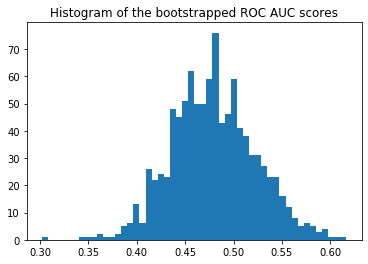

Confidence interval for the score: [0.4117 - 0.5528]


In [35]:
#Boostrapping calculated 95% CI
y_pred = lg_probs
y_true = read_ytest2

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [36]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
read_ytest2=read_ytest2.reshape((14649,))
y_pred = lg_probs
y_true = read_ytest2

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.47788067675868207
AUC COV: 0.0019309876555635688
95% AUC CI: [0.39175397 0.56400738]


# Artificial Neural Network

## SMOTE First

In [37]:
# !pip install imblearn

In [38]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [39]:
smt = SMOTE()
X_train = read_Xtrain2
X_test = read_Xtest2
y_train = read_ytrain2
y_test = read_ytest2
X_train, y_train = smt.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### To test for the SMOTE

In [40]:
read_ytrain2.shape

(21494, 1)

In [41]:
read_ytrain2[read_ytrain2['outcome']==0].shape

(21416, 1)

In [42]:
read_ytrain2[read_ytrain2['outcome']==1].shape

(78, 1)

In [43]:
X_train.shape

(42832, 19)

In [44]:
y_train = pd.DataFrame(y_train)
y_train.columns = ['outcome']
y_train[y_train['outcome']==0].shape

(21416, 1)

In [45]:
y_train[y_train['outcome']==1].shape

(21416, 1)

In [46]:
X_train.shape

(42832, 19)

##  ANN from here

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler = scaler.fit(X_train)
X_trains = scaler.transform(X_train)
X_tests = scaler.transform(X_test)
# y_train
# y_test

In [48]:
from sklearn.neural_network import MLPClassifier
seed(1)
# skf = StratifiedKFold(n_splits=5)
params3 = {'alpha' : [0.0001,0.01],
           'power_t': [0.5,0.75],
           'max_iter': [200,250]}
mlp1 = MLPClassifier(solver='lbfgs', random_state=1)
mlp1 = GridSearchCV(mlp1, cv=5, param_grid=params3, scoring = 'roc_auc',refit = True, 
                    n_jobs=-1, verbose = 5, return_train_score=True)

mlp1.fit(X_trains, y_train)
mlp1.cv_results_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:  1.0min remaining:   32.9s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  1.1min remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mean_fit_time': array([20.03796577, 20.12409124, 19.96209979, 19.84366527, 19.97163229,
        19.32875395, 19.26228871, 10.5093688 ]),
 'std_fit_time': array([0.53757763, 0.55288829, 0.40897657, 0.58283489, 0.96777147,
        1.03007631, 0.75743051, 4.11790708]),
 'mean_score_time': array([0.07484741, 0.07677236, 0.08022375, 0.07389636, 0.07059608,
        0.06423168, 0.05200181, 0.02085433]),
 'std_score_time': array([0.01192374, 0.00756909, 0.01119031, 0.0113187 , 0.00645661,
        0.01178538, 0.01444176, 0.00624069]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.0001, 0.01, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[200, 200, 250, 250, 200, 200, 250, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_power_t': masked_array(data=[

In [49]:
mlp1.best_estimator_

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [50]:
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier(solver='lbfgs', random_state=1)
# mlp = mlp.fit(X_trains, y_train)
# ann_pred1 = mlp.predict(X_tests)
# ann_pred1

In [51]:
# mlp

In [52]:
ann_pred1 = mlp1.best_estimator_.predict(X_tests)
ann_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [53]:
prob3 = mlp1.best_estimator_.predict_proba(X_tests) 
prob3

array([[1.00000000e+00, 6.60463288e-12],
       [1.00000000e+00, 9.96650943e-30],
       [1.00000000e+00, 4.58060948e-41],
       ...,
       [1.00000000e+00, 6.68074818e-55],
       [1.00000000e+00, 1.34052674e-13],
       [1.00000000e+00, 4.50683857e-49]])

In [54]:
ann_matrix = metrics.confusion_matrix(y_test, ann_pred1)
ann_matrix

array([[14496,   103],
       [   50,     0]])

In [55]:
target_names1 = ['Not in 30 days', 'Readmitted within 30 days']
print("", classification_report(y_test, ann_pred1, 
                                target_names=target_names1))

                            precision    recall  f1-score   support

           Not in 30 days       1.00      0.99      0.99     14599
Readmitted within 30 days       0.00      0.00      0.00        50

                 accuracy                           0.99     14649
                macro avg       0.50      0.50      0.50     14649
             weighted avg       0.99      0.99      0.99     14649



In [56]:
ann_probs = mlp1.best_estimator_.predict_proba(X_tests)[:,1]
print(roc_auc_score(y_test, ann_probs))

0.5075183231728201


In [57]:
mean_confidence_interval(y_test, confidence=0.95)

(0.003413202266366305, 0.0024686339150578173, 0.004357770617674793)

In [58]:
st.t.interval(0.95, len(y_test)-1, 
              loc=np.mean(y_test), scale=st.sem(y_test))

(0.0024686339150578173, 0.004357770617674793)

Original ROC area: 0.5075


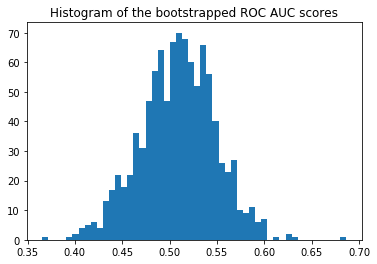

Confidence interval for the score: [0.4412 - 0.5704]


In [59]:
#Boostrapping calculated 95% CI
y_pred = ann_probs
y_true = y_test

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [60]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
y_pred = ann_probs
y_true = y_test

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.5075183231728201
AUC COV: 0.001641132475367912
95% AUC CI: [0.42811843 0.58691822]


# Random Forest

In [62]:
# read_Xtrain2
# read_Xtest2
# read_ytrain2
# read_ytest2

In [63]:
from sklearn.ensemble import RandomForestClassifier
seed(42)

params4 = {'n_estimators' : [10,100,150],
           'min_samples_leaf': [1,2,3]}
rf1 = RandomForestClassifier(random_state=42)
rf1 = GridSearchCV(rf1, cv=5, param_grid=params4, scoring = 'roc_auc',refit = True, 
                   n_jobs=-1, verbose = 5, return_train_score=True)

rf1.fit(read_Xtrain2, read_ytrain2)
rf1.cv_results_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:   10.6s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:   13.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   14.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'mean_fit_time': array([0.28285446, 2.79317765, 4.17807322, 0.28368745, 2.84362769,
        4.27447343, 0.29339499, 2.88624263, 3.28689208]),
 'std_fit_time': array([0.00912064, 0.06771047, 0.10350626, 0.00309684, 0.12585007,
        0.11082721, 0.01176973, 0.03636681, 0.31933991]),
 'mean_score_time': array([0.0130074 , 0.06990938, 0.10596676, 0.01274948, 0.07116423,
        0.09457936, 0.01342211, 0.06731086, 0.0575665 ]),
 'std_score_time': array([0.00027365, 0.00119611, 0.00156421, 0.00044756, 0.00391362,
        0.01012576, 0.00032316, 0.00848722, 0.00418184]),
 'param_min_samples_leaf': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 100, 150, 10, 100, 150, 10, 100, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False],
       

In [64]:
rf1.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [65]:
rf_pred1 = rf1.best_estimator_.predict(read_Xtest2)
rf_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
prob4 = rf1.best_estimator_.predict_proba(read_Xtest2) 
prob4

array([[0.99666667, 0.00333333],
       [0.975     , 0.025     ],
       [0.94866667, 0.05133333],
       ...,
       [1.        , 0.        ],
       [0.99333333, 0.00666667],
       [1.        , 0.        ]])

In [67]:
rf_matrix1 = metrics.confusion_matrix(read_ytest2, rf_pred1)
rf_matrix1

array([[14599,     0],
       [   50,     0]])

In [68]:
target_names1 = ['Not in 30 days', 'Readmitted within 30 days']
print("", classification_report(read_ytest2, rf_pred1, 
                                target_names=target_names1))

                            precision    recall  f1-score   support

           Not in 30 days       1.00      1.00      1.00     14599
Readmitted within 30 days       0.00      0.00      0.00        50

                 accuracy                           1.00     14649
                macro avg       0.50      0.50      0.50     14649
             weighted avg       0.99      1.00      0.99     14649



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
rf_probs = rf1.best_estimator_.predict_proba(read_Xtest2)[:,1]
print(roc_auc_score(read_ytest2, rf_probs))

0.5017823138571136


Original ROC area: 0.5018


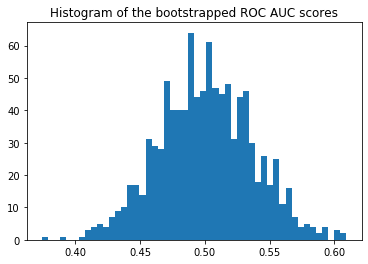

Confidence interval for the score: [0.4423 - 0.5618]


In [70]:
#Boostrapping calculated 95% CI
y_pred = rf_probs
y_true = read_ytest2

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [71]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
y_pred = rf_probs
y_true = read_ytest2

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.5017823138571135
AUC COV: 0.0013611946962794295
95% AUC CI: [0.42947067 0.57409395]


# Gradient Boosting Machines

In [72]:
read_Xtrain2.head()

,PatientGender,PatientRace,PatientEncounterAge,CBC..ABSOLUTE.LYMPHOCYTES,CBC..ABSOLUTE.NEUTROPHILS,CBC..BASOPHILS,CBC..EOSINOPHILS,CBC..HEMATOCRIT,CBC..HEMOGLOBIN,CBC..PLATELET.COUNT,CBC..RED.BLOOD.CELL.COUNT,CBC..WHITE.BLOOD.CELL.COUNT,METABOLIC..ALBUMIN,METABOLIC..BILI.TOTAL,METABOLIC..BUN,METABOLIC..CALCIUM,METABOLIC..CREATININE,METABOLIC..POTASSIUM,METABOLIC..SODIUM
0,1,1,36.456455,16.1,77.9,0.2,0.4,49.6,16.2,339.2,5.8,6.4,2.7,0.9,15.6,8.1,1.2,4.7,140.9
1,1,1,21.408437,32.8,76.4,0.0,0.1,35.9,14.8,386.0,4.8,10.7,5.8,0.8,12.6,11.1,0.9,4.1,135.5
3,1,1,42.671151,23.4,66.2,0.1,0.4,40.4,18.7,408.7,3.2,8.5,3.7,0.3,15.1,7.9,0.7,5.3,150.0
9,1,3,27.803538,29.4,64.5,0.0,0.3,42.9,13.4,271.7,5.9,6.4,3.2,0.0,25.9,11.8,0.7,3.3,145.2
12,1,1,66.119312,22.4,77.5,0.1,0.2,39.3,13.3,135.0,5.3,3.0,5.7,1.1,25.9,11.1,1.2,4.7,136.0


In [73]:
from sklearn.ensemble import GradientBoostingClassifier
seed(10)

params5 = {'learning_rate' : [0.05,0.1,0.2],
           'n_estimators': [100,150],
           'min_samples_split': [2,3,4]}
gbm1 = GradientBoostingClassifier(random_state=10)
gbm1 = GridSearchCV(gbm1, cv=5, param_grid=params5, scoring = 'roc_auc',refit = True, 
                    n_jobs=-1, verbose = 5, return_train_score=True)

gbm1.fit(read_Xtrain2, read_ytrain2)
gbm1.cv_results_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  86 out of  90 | elapsed:   34.8s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   36.0s finished
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mean_fit_time': array([3.14430537, 4.66901126, 3.22242279, 5.04610419, 3.490838  ,
        5.6182436 , 3.71450071, 5.5807796 , 3.64367723, 5.26027641,
        3.47499132, 5.1421937 , 3.42881041, 5.19725356, 3.45074306,
        5.11695271, 3.34255419, 3.27638688]),
 'std_fit_time': array([0.04620515, 0.05551474, 0.09116727, 0.06166162, 0.06277106,
        0.13388481, 0.05391693, 0.09711928, 0.0848055 , 0.06619662,
        0.08144634, 0.07152544, 0.07926821, 0.09208795, 0.01771899,
        0.11685436, 0.04269919, 0.6721486 ]),
 'mean_score_time': array([0.01672258, 0.02444882, 0.01834774, 0.02433524, 0.01909771,
        0.02615447, 0.01880374, 0.02562137, 0.01856661, 0.02241302,
        0.01907263, 0.02244263, 0.0200892 , 0.02315779, 0.01781116,
        0.01922665, 0.01633358, 0.01152754]),
 'std_score_time': array([0.00034095, 0.00249744, 0.00140721, 0.00146483, 0.00143651,
        0.00221613, 0.00085346, 0.00197047, 0.00059951, 0.00050705,
        0.00165574, 0.00061754, 0.00377675, 

In [74]:
gbm1.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [75]:
gbm_pred1 = gbm1.best_estimator_.predict(read_Xtest2)
gbm_pred1

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
prob5 = gbm1.best_estimator_.predict_proba(read_Xtest2) 
prob5

array([[9.99375485e-01, 6.24515243e-04],
       [9.93204431e-01, 6.79556866e-03],
       [9.97519579e-01, 2.48042053e-03],
       ...,
       [9.99899119e-01, 1.00881367e-04],
       [9.98525010e-01, 1.47499011e-03],
       [9.99034825e-01, 9.65174759e-04]])

In [77]:
gbm_matrix1 = metrics.confusion_matrix(read_ytest2, gbm_pred1)
gbm_matrix1

array([[14560,    39],
       [   50,     0]])

In [78]:
target_names1 = ['Not in 30 days', 'Readmitted within 30 days']
print("", classification_report(read_ytest2, gbm_pred1, 
                                target_names=target_names1))

                            precision    recall  f1-score   support

           Not in 30 days       1.00      1.00      1.00     14599
Readmitted within 30 days       0.00      0.00      0.00        50

                 accuracy                           0.99     14649
                macro avg       0.50      0.50      0.50     14649
             weighted avg       0.99      0.99      0.99     14649



In [79]:
gbm_probs = gbm1.best_estimator_.predict_proba(read_Xtest2)[:,1]
print(roc_auc_score(read_ytest2, gbm_probs))

0.5060826083978355


Original ROC area: 0.5061


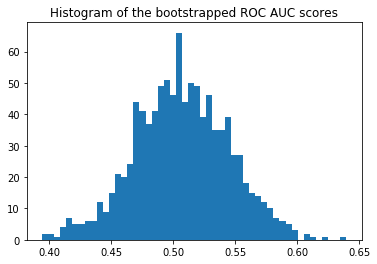

Confidence interval for the score: [0.4454 - 0.5693]


In [80]:
#Boostrapping calculated 95% CI
y_pred = gbm_probs
y_true = read_ytest2

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [81]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
y_pred = gbm_probs
y_true = read_ytest2

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.5060826083978355
AUC COV: 0.001513806136731901
95% AUC CI: [0.42982499 0.58234022]


---------------------

# Section 2: Gusto Study
### Using the training datasets, create the following models:
1.	GLM model : This model utilizes all features to predict 30-day mortality in a logistic regression framework.
2.	Ridge Regression model : This model utilizes all features to predict 30-day mortality in a logistic regression framework with regularization. Utilize a 5 fold cross validation to build the parameters for your model. 


# Gusto

In [82]:
gusto = pd.read_csv("gusto_data.csv")
gusto['GROUP'] = gusto['GROUP'].replace('west',0)
gusto['GROUP'] = gusto['GROUP'].replace('sample2',1)
gusto['GROUP'] = gusto['GROUP'].replace('sample4',2)
gusto['GROUP'] = gusto['GROUP'].replace('sample5',3)
gusto['GROUP'] = gusto['GROUP'].astype('category').cat.codes

In [83]:
gu_train = gusto.loc[(gusto['GROUP'] == 1
                     ) | (gusto['GROUP'] == 2
                         ) | (gusto['GROUP'] == 3)]
gu_test = gusto[gusto['GROUP']==0]

gu_Xtrain = gu_train.drop("DAY30",axis=1)
gu_ytrain = gu_train[['DAY30']]
gu_Xtest = gu_test.drop("DAY30",axis=1)
gu_ytest = gu_test[['DAY30']]

# GLM Model

In [84]:
seed(0)

params6 = {'tol' : [1e-6,1e-5,1e-4,1e-3,1e-2],
           'C': [0.5,1.0,1.5,2.0,2.5]}
lg2 = LogisticRegression(random_state=0, solver='warn',multi_class='warn')
lg2 = GridSearchCV(lg2, cv=5, param_grid=params6, scoring = 'roc_auc',refit = True, 
                   n_jobs=-1, verbose = 5, return_train_score=True)

lg2.fit(gu_Xtrain, gu_ytrain)
lg2.cv_results_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 102 out of 125 | elapsed:    2.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mean_fit_time': array([0.01776662, 0.01929483, 0.01552296, 0.01274166, 0.01164804,
        0.01790109, 0.01682034, 0.01415443, 0.01191001, 0.00713024,
        0.01401224, 0.01012397, 0.01103315, 0.00855217, 0.00594544,
        0.0128159 , 0.01101751, 0.01181641, 0.01065273, 0.00775452,
        0.01522622, 0.01626968, 0.01379275, 0.01147804, 0.00932965]),
 'std_fit_time': array([0.00063286, 0.00134065, 0.00224109, 0.00091138, 0.00167021,
        0.00115815, 0.00095936, 0.00092371, 0.00206895, 0.00104914,
        0.00087095, 0.00051273, 0.00050219, 0.00047801, 0.00064942,
        0.00086447, 0.00156735, 0.00034665, 0.00105303, 0.00113632,
        0.00082124, 0.00299444, 0.00062356, 0.00043167, 0.00114164]),
 'mean_score_time': array([0.00463786, 0.00608678, 0.00451694, 0.00449662, 0.00473275,
        0.00529971, 0.00495882, 0.00479684, 0.0034174 , 0.00309405,
        0.00318289, 0.00240445, 0.00314813, 0.00272183, 0.00283775,
        0.00337129, 0.0033565 , 0.00340214, 0.00347781, 0.00

In [85]:
lg2.best_estimator_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
lg_pred2 = lg2.best_estimator_.predict(gu_Xtest)
lg_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [87]:
prob6 = lg2.best_estimator_.predict_proba(gu_Xtest) 
prob6

array([[0.91372545, 0.08627455],
       [0.96230571, 0.03769429],
       [0.96092094, 0.03907906],
       ...,
       [0.96151863, 0.03848137],
       [0.89257942, 0.10742058],
       [0.97582683, 0.02417317]])

In [88]:
lg_matrix2 = metrics.confusion_matrix(gu_ytest, lg_pred2)
lg_matrix2

array([[2038,   15],
       [ 116,   19]])

In [89]:
target_names2 = ['Still alive at 30 day', 'Died in 30 days']
print("", classification_report(gu_ytest, lg_pred2, target_names=target_names2))

                        precision    recall  f1-score   support

Still alive at 30 day       0.95      0.99      0.97      2053
      Died in 30 days       0.56      0.14      0.22       135

             accuracy                           0.94      2188
            macro avg       0.75      0.57      0.60      2188
         weighted avg       0.92      0.94      0.92      2188



In [90]:
lg_probs2 = lg2.best_estimator_.predict_proba(gu_Xtest)[:,1]
print(roc_auc_score(gu_ytest, lg_probs2))

0.8302033158341001


Original ROC area: 0.8302


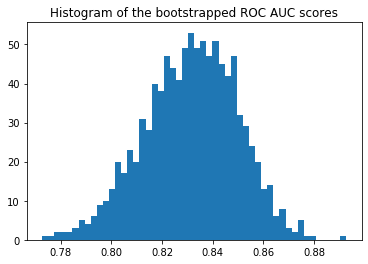

Confidence interval for the score: [0.8000 - 0.8594]


In [91]:
#Boostrapping calculated 95% CI
gu_ytest = gu_ytest.values
y_pred = lg_probs2
y_true = gu_ytest

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [92]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
gu_ytest = gu_ytest.reshape((2188,))
y_pred = lg_probs2
y_true = gu_ytest

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.8302033158341
AUC COV: 0.0003444411856651161
95% AUC CI: [0.7938281  0.86657854]


# Ridge Regression Model

In [93]:
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv=5, fit_intercept=True, scoring=None, normalize=False)
ridgecv=ridgecv.fit(gu_Xtrain,gu_ytrain)
gu_ridgecv = ridgecv.predict(gu_Xtest)
roc_auc_score(gu_ytest, gu_ridgecv)

0.8279590842669263

Original ROC area: 0.8280


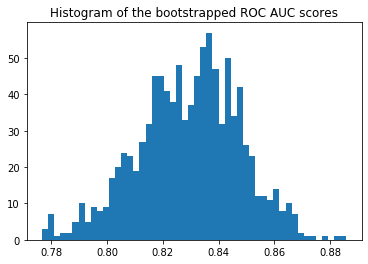

Confidence interval for the score: [0.7982 - 0.8586]


In [94]:
#Boostrapping calculated 95% CI
y_pred = gu_ridgecv
y_true = gu_ytest

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [95]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
gu_ridgecv = gu_ridgecv.reshape((2188,))
y_pred = gu_ridgecv
y_true = gu_ytest

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.8279590842669264
AUC COV: 0.0003523557006508896
95% AUC CI: [0.79116833 0.86474984]


# Artificial Neural Network

In [96]:
scaler = StandardScaler()
# Fit only to the training data
scaler = scaler.fit(gu_Xtrain)
gu_Xtrains = scaler.transform(gu_Xtrain)
gu_Xtests = scaler.transform(gu_Xtest)

In [97]:
seed(1)
# skf = StratifiedKFold(n_splits=5)
params7 = {'alpha' : [0.0001,0.01],
           'power_t': [0.5,0.75],
           'max_iter': [200,250]}
mlp2 = MLPClassifier(solver='lbfgs', random_state=1)
mlp2 = GridSearchCV(mlp2, cv=5, param_grid=params7, scoring = 'roc_auc',refit = True, 
                    n_jobs=-1, verbose = 5, return_train_score=True)

mlp2.fit(gu_Xtrains, gu_ytrain)
mlp2.cv_results_


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  40 | elapsed:    3.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:    3.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mean_fit_time': array([0.24871483, 0.30837779, 0.31661859, 0.32108974, 0.43691769,
        0.4199564 , 0.36917367, 0.28871627]),
 'std_fit_time': array([0.02404706, 0.02613244, 0.02350786, 0.02054395, 0.04495035,
        0.02794388, 0.00951518, 0.02044128]),
 'mean_score_time': array([0.00638633, 0.00591998, 0.00691061, 0.00545778, 0.00723748,
        0.00562401, 0.00423288, 0.00237317]),
 'std_score_time': array([0.00081622, 0.00028137, 0.00288459, 0.00023585, 0.00296454,
        0.00142962, 0.00136468, 0.00043304]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.0001, 0.01, 0.01, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[200, 200, 250, 250, 200, 200, 250, 250],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_power_t': masked_array(data=[0.5, 0.7

In [98]:
mlp2.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [99]:
ann_pred2 = mlp2.best_estimator_.predict(gu_Xtests)
ann_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
prob7 = mlp2.best_estimator_.predict_proba(gu_Xtests) 
prob7

array([[1.00000000e+00, 4.92987998e-92],
       [1.00000000e+00, 3.30660487e-78],
       [1.00000000e+00, 5.34809233e-83],
       ...,
       [1.00000000e+00, 1.21594736e-30],
       [1.00000000e+00, 8.23828743e-48],
       [1.00000000e+00, 8.12154336e-39]])

In [101]:
ann_matrix2 = metrics.confusion_matrix(gu_ytest, ann_pred2)
ann_matrix2

array([[1947,  106],
       [  93,   42]])

In [102]:
target_names2 = ['Still alive at 30 day', 'Died in 30 days']
print("", classification_report(gu_ytest, ann_pred2, 
                                target_names=target_names2))

                        precision    recall  f1-score   support

Still alive at 30 day       0.95      0.95      0.95      2053
      Died in 30 days       0.28      0.31      0.30       135

             accuracy                           0.91      2188
            macro avg       0.62      0.63      0.62      2188
         weighted avg       0.91      0.91      0.91      2188



In [103]:
ann_probs2 = mlp2.best_estimator_.predict_proba(gu_Xtests)[:,1]
print(roc_auc_score(gu_ytest, ann_probs2))

0.759576771120853


Original ROC area: 0.7596


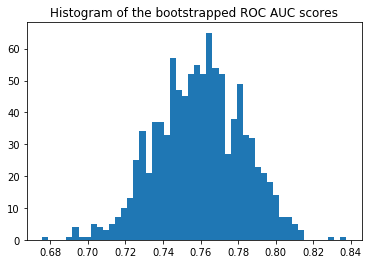

Confidence interval for the score: [0.7232 - 0.7963]


In [104]:
#Boostrapping calculated 95% CI
y_pred = ann_probs2
y_true = gu_ytest

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [105]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
y_pred = ann_probs2
y_true = gu_ytest

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.759576771120853
AUC COV: 0.0005295762772071846
95% AUC CI: [0.71447305 0.80468049]


# Random Forest

In [106]:
seed(42)

params8 = {'n_estimators' : [10,100,150],
           'min_samples_leaf': [1,2,3]}
rf2 = RandomForestClassifier(random_state=42)
rf2 = GridSearchCV(rf2, cv=5, param_grid=params8, scoring = 'roc_auc',refit = True, 
                   n_jobs=-1, verbose = 5, return_train_score=True)

rf2.fit(gu_Xtrain,gu_ytrain)
rf2.cv_results_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  45 | elapsed:    3.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  42 out of  45 | elapsed:    3.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.4s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'mean_fit_time': array([0.0431448 , 0.31748538, 0.47422519, 0.03773494, 0.31329279,
        0.48183465, 0.03696904, 0.31390924, 0.33778834]),
 'std_fit_time': array([0.00311095, 0.00492449, 0.00975234, 0.00180364, 0.01112705,
        0.00534404, 0.00012415, 0.00353635, 0.04553103]),
 'mean_score_time': array([0.00668821, 0.02331481, 0.03344364, 0.00601273, 0.02352328,
        0.03404474, 0.0068069 , 0.02332582, 0.01948948]),
 'std_score_time': array([0.00034828, 0.00066868, 0.00229864, 0.00027037, 0.00032041,
        0.00068371, 0.00073997, 0.00156654, 0.00032613]),
 'param_min_samples_leaf': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 100, 150, 10, 100, 150, 10, 100, 150],
              mask=[False, False, False, False, False, False, False, False,
                    False],
       

In [107]:
rf2.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [108]:
rf_pred2 = rf2.best_estimator_.predict(gu_Xtest)
rf_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
prob8 = rf2.best_estimator_.predict_proba(gu_Xtest) 
prob8

array([[0.96881419, 0.03118581],
       [0.94229728, 0.05770272],
       [0.99634343, 0.00365657],
       ...,
       [0.97513973, 0.02486027],
       [0.83568952, 0.16431048],
       [0.97687497, 0.02312503]])

In [110]:
rf_matrix2 = metrics.confusion_matrix(gu_ytest, rf_pred2)
rf_matrix2

array([[2051,    2],
       [ 128,    7]])

In [111]:
print("", classification_report(gu_ytest, rf_pred2, 
                                target_names=target_names2))

                        precision    recall  f1-score   support

Still alive at 30 day       0.94      1.00      0.97      2053
      Died in 30 days       0.78      0.05      0.10       135

             accuracy                           0.94      2188
            macro avg       0.86      0.53      0.53      2188
         weighted avg       0.93      0.94      0.92      2188



In [112]:
rf_probs2 = rf2.best_estimator_.predict_proba(gu_Xtest)[:,1]
print(roc_auc_score(gu_ytest, rf_probs2))

0.885331312803305


Original ROC area: 0.8853


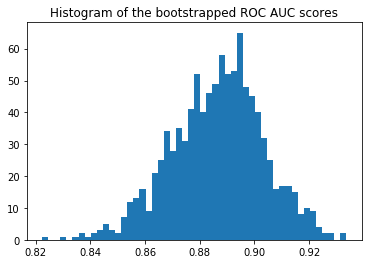

Confidence interval for the score: [0.8575 - 0.9138]


In [113]:
#Boostrapping calculated 95% CI
y_pred = rf_probs2
y_true = gu_ytest

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [114]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
y_pred = rf_probs2
y_true = gu_ytest

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.885331312803305
AUC COV: 0.0002835084573262921
95% AUC CI: [0.85233001 0.91833262]


# Gradient Boosting Machines

In [115]:
seed(10)

params9 = {'learning_rate' : [0.05,0.1,0.2],
           'n_estimators': [100,150],
           'min_samples_split': [2,3,4]}
gbm2 = GradientBoostingClassifier(random_state=10)
gbm2 = GridSearchCV(gbm2, cv=5, param_grid=params9, scoring = 'roc_auc',refit = True, 
                    n_jobs=-1, verbose = 5, return_train_score=True)

gbm2.fit(gu_Xtrain,gu_ytrain)
gbm2.cv_results_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  86 out of  90 | elapsed:    4.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    4.5s finished
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'mean_fit_time': array([0.22256212, 0.34172802, 0.23362408, 0.35020294, 0.22939553,
        0.35094404, 0.23809605, 0.36700315, 0.24748402, 0.36184278,
        0.24461427, 0.37012062, 0.25583777, 0.38549562, 0.25356526,
        0.36602039, 0.24349747, 0.2658812 ]),
 'std_fit_time': array([0.00385851, 0.00451759, 0.00361519, 0.00726972, 0.00304873,
        0.00746689, 0.00321686, 0.00459206, 0.00859492, 0.00679286,
        0.00589788, 0.01086037, 0.00651552, 0.00786239, 0.00857925,
        0.01194572, 0.0051395 , 0.02943227]),
 'mean_score_time': array([0.00541196, 0.00759826, 0.00531902, 0.00563464, 0.0054883 ,
        0.00552077, 0.00528045, 0.0055562 , 0.00560541, 0.00684323,
        0.00533257, 0.00595651, 0.00610633, 0.00580502, 0.00594573,
        0.00556779, 0.00638723, 0.00353961]),
 'std_score_time': array([0.00019735, 0.00059642, 0.00021568, 0.00039022, 0.00071267,
        0.00013416, 0.00019982, 0.00010537, 0.00042535, 0.00228823,
        0.00014897, 0.00012158, 0.0014703 , 

In [116]:
gbm2.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=4,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [117]:
gbm_pred2 = gbm2.best_estimator_.predict(gu_Xtest)
gbm_pred2

array([0, 0, 0, ..., 0, 0, 0])

In [118]:
prob9 = gbm2.best_estimator_.predict_proba(gu_Xtest) 
prob9

array([[0.947186  , 0.052814  ],
       [0.97310495, 0.02689505],
       [0.97898104, 0.02101896],
       ...,
       [0.9711283 , 0.0288717 ],
       [0.87880754, 0.12119246],
       [0.98384301, 0.01615699]])

In [119]:
gbm_matrix2 = metrics.confusion_matrix(gu_ytest, gbm_pred2)
gbm_matrix2

array([[2044,    9],
       [ 113,   22]])

In [120]:
print("", classification_report(gu_ytest, gbm_pred2, 
                                target_names=target_names2))

                        precision    recall  f1-score   support

Still alive at 30 day       0.95      1.00      0.97      2053
      Died in 30 days       0.71      0.16      0.27       135

             accuracy                           0.94      2188
            macro avg       0.83      0.58      0.62      2188
         weighted avg       0.93      0.94      0.93      2188



In [121]:
gbm_probs2 = gbm2.best_estimator_.predict_proba(gu_Xtest)[:,1]
print(roc_auc_score(gu_ytest, gbm_probs2))

0.8720806047157728


Original ROC area: 0.8721


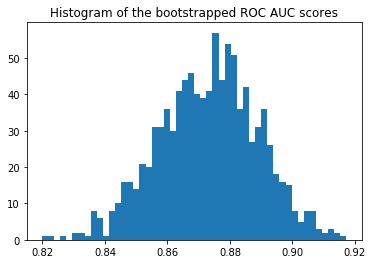

Confidence interval for the score: [0.8468 - 0.8985]


In [122]:
#Boostrapping calculated 95% CI
y_pred = gbm_probs2
y_true = gu_ytest

print("Original ROC area: {:0.4f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    
import matplotlib.pyplot as plt
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.4f} - {:0.4}]".format(
    confidence_lower, confidence_upper))

In [123]:
#pROC calculated 95% CI without bootstrapping
alpha = .95
y_pred = gbm_probs2
y_true = gu_ytest

auc, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc)
print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

AUC: 0.8720806047157728
AUC COV: 0.000262844614256567
95% AUC CI: [0.84030472 0.90385649]


--------------------